<a href="https://colab.research.google.com/github/PashaLikhterov/Deep-Learning/blob/main/Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installations
This project requires dataset fetching and some preparations. In this section we present the installations that have been made beforehand.

In [ ]:
# Creating directory fot dataset fetching
! mkdir '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle'

In [ ]:
 #Importing the dataset from kaggle
 ! pip install -q kaggle
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
 ! unzip gtzan-dataset-music-genre-classification.zip -d '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.21G/1.21G [00:10<00:00, 167MB/s]
100% 1.21G/1.21G [00:10<00:00, 126MB/s]



#Building the dataset

## Our dataset
We are using the GTZAN dataset which includes:
1. **Genres Original folder** - consists of **10 folders of 10 different genres**. In each genre folder there is **100 .wav files**. Each .wav file is 30 seconds long. This data is our raw input.
2. **Images Original folder** - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)
3. 2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.
## Relative Work
In order to maximise the results according to the article
[Music Genre Classification](http://cs229.stanford.edu/proj2018/report/21.pdf) we shall use data precprocessing insted of using raw data.
In this article they also present the Mel-spectogram approach for CNN based models.
###What is Mel-spectogram?
Mel-spectogram is a way of featurizing audio closer to the way human percieve audio (i.e in log frequency). In order to calculate the Mel-spectogram we need to apply STFT on our raw audio.

$STFT{x[n]}(m,w) = ∑_{n}x[n]w[n-m]e^{-j𝞈n}$

Where:
x[n] - is our raw audio signal.
w[n-m] - shifted window.
𝞈 - frequency axis
m - shift in time domain



##Visual representation of the dataset

In [ ]:
# Inspect an audio file from the dataset.
print("Presenting 5th blues .wav file")
sample_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/blues/blues.00005.wav'
# if you want to listen to the audio, uncomment below.
display.Audio(sample_path)

Presenting 5th blues .wav file


y: [-0.02429199 -0.02975464 -0.00961304 ...  0.13458252  0.0619812
 -0.00091553] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


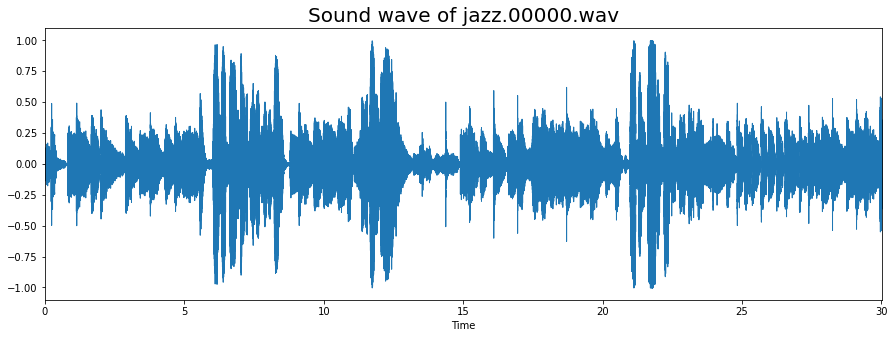

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

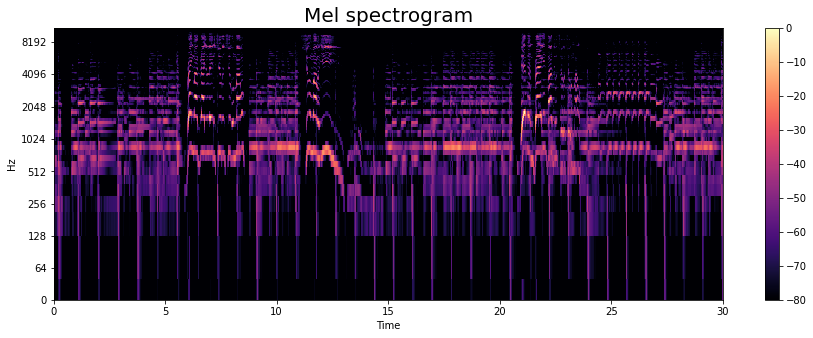

In [ ]:
# Convert sound wave to mel spectrogram.
y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

(288, 432, 4)


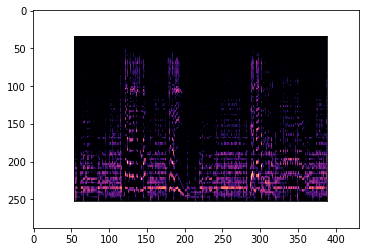

In [ ]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/blues/blues00005.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

#Helping functions
Here we presenet the implementaion of functions that were used in each part of the project.
The following functions could be used without any changes for each part:
<p>
1. Start - Mounting google drive.
2. Setting device to gpu - returns a devce paramater for gpu utilization during training.
3. Splitting the dataset - this function splits the root directory dataset.
4. Train Function - given a model and parameters for specific dataset, trains it andreturnsthe corrseponding losses.
5. Plot Training loss - giving the vectors from (4) plots the corresponding graphs.
</p>

##Start
Mount the Drive here, and import all neeeded libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path_file = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import json
import math
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. Setting device to gpu
Turn on the gpu.

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device
device = set_device()

GPU is enabled in this notebook.


##2. Splitting the dataset function
This Function in the following manner - given 4 folders:
1.root_path - the root file path where each genre represent a folder and each genre contains the dataset files.
2. train_path, valid_path, test_path - 3 filders to where we copy the neccesary dataset files in the same manner they were saved in the root_path. Example of the folder structure given under the function implementation.

In [ ]:
def split_dataSet(root_path, train_path, valid_path, test_path):
  '''root_path - is the root folder where the spectograms allocated.
  train_path, valid_path, test_path - folder where the train, validation and testing data respectively will be.'''
  folder_names = [train_path, valid_path, test_path]
  print(folder_names)
  # Loop over all genres.
  genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
  for g in genres.values():
    # find all images & split in train, test, and validation
    src_file_paths= []
    for im in glob.glob(os.path.join(root_path, f'{g}',"*.png*"), recursive=True):
      src_file_paths.append(im)
    random.shuffle(src_file_paths)
    total_len = len(src_file_paths)
    idx_1 = int(math.ceil(0.1*total_len))
    idx_2 = int(math.ceil(0.2*total_len))
    test_files = src_file_paths[0:idx_1]
    val_files = src_file_paths[idx_1:idx_2]
    train_files = src_file_paths[idx_2:]
    print(f"For genre: {g}, num of train files: {len(train_files)}, num of validation files:"\
    +f" {len(val_files)}, num of test files: {len(test_files)}")
    #  make destination folders for train and test images
    for f in folder_names:
      if not os.path.exists(os.path.join(f , f"{g}")):
        os.mkdir(os.path.join(f , f"{g}"))

    # copy training and testing images over
    for f in train_files:
      shutil.copy(f, os.path.join(train_path + f"{g}"))
    for f in test_files:
      shutil.copy(f, os.path.join(test_path + f"{g}"))
    for f in val_files:
      shutil.copy(f, os.path.join(valid_path + f"{g}"))

In [ ]:
! ls -l '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'

total 627288
drwx------ 2 root root      4096 Jan 22 09:43 blues
drwx------ 2 root root      4096 Jan 22 09:43 classical
drwx------ 2 root root      4096 Jan 22 09:43 country
-rw------- 1 root root 642301302 Feb 17 08:55 data_10.json
drwx------ 2 root root      4096 Jan 22 09:43 disco
drwx------ 2 root root      4096 Jan 22 09:43 hiphop
drwx------ 2 root root      4096 Jan 22 09:43 jazz
drwx------ 2 root root      4096 Jan 22 09:43 metal
drwx------ 2 root root      4096 Jan 22 09:43 pop
drwx------ 2 root root      4096 Jan 22 09:43 reggae
drwx------ 2 root root      4096 Jan 22 09:43 rock


## 3. Create custom dataset

Here we implement class for storing our datasets in **Part 1** and **Part 2**. The differnce in the datasets are the image dimensions and where the relevant information is stored (we must cllip the axises and the white background to avoid noise in our model).

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, root, original = False):
    ds = datasets.ImageFolder(root)
    if not original:
      self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            lambda img: transforms.functional.crop(img,36,122,210,210)
        ])
    else:
      self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            lambda img: transforms.functional.crop(img,35,55,220,340)
        ])

    self.samples = [sample for sample in tqdm(ds)]

  def __getitem__(self, index):
    return self.transforms(self.samples[index][0]), self.samples[index][1]
    
  def __len__(self):
    return len(self.samples)
    

In [ ]:

def create_Datasets(train_dir, val_dir, test_dir, batch_size = 64, original = False):
  '''This function given all the dataset paths, return a data object for each set.'''
  # Data loading.
  norm_mean = 0.5 
  norm_std = 0.5

  #Training Dataset
  melspecs_30s_dataset_training = CustomDataset(train_dir, original)
  train_loader = torch.utils.data.DataLoader(
      melspecs_30s_dataset_training, batch_size= batch_size, shuffle=True, num_workers=2)

  #Validatoin Dataset
  melspecs_30s_dataset_val = CustomDataset(val_dir, original)
  val_loader = torch.utils.data.DataLoader(
      melspecs_30s_dataset_val, batch_size=batch_size, shuffle=True, )

  #Test
  melspecs_30s_dataset_test = CustomDataset(test_dir, original)
  test_loader = torch.utils.data.DataLoader(
      melspecs_30s_dataset_test, batch_size=batch_size, shuffle=True, )
  return train_loader, val_loader, test_loader

## 4. Train Function

Given a model and hyper_parameters implemets the training method.

In [ ]:
def train(model, device, train_loader, validation_loader,
          epochs ,lr ,weight_decay=None, flag_rnn=False, batch_size =64):
  '''Model training function for each model'''
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
      tepochs.set_description('Training')
      for epoch in tepochs:
        model.train()
        # keep track of the running loss
        running_loss = 0.
        correct, total = 0, 0

        for data, target in train_loader:
          # getting the training set

          #******For section 3.2 *****
          # input1 = data[0]
          # input2 = data[1]
          # input1,input2, target = input1.to(device), input2.to(device), target.to(device)
          # output = model((input1,input2))
          
          #******For the rest of the project ******
          data, target = data.to(device), target.to(device)
          # Get the model output (call the model with the data from this batch)
          output = model(data)
          # Zero the gradients out)
          optimizer.zero_grad()
          # Get the Loss
          loss  = criterion(output, target)
          # Calculate the gradients
          loss.backward()
          # Update the weights (using the training step of the optimizer)
          optimizer.step()

          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()  # add the loss for this batch

          # get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

        # append the loss for this epoch
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)

        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0

        for data, target in validation_loader:
          # getting the validation set
          #******For section 3.2 *****
          # input1 = data[0]
          # input2 = data[1]
          # input1,input2, target = input1.to(device), input2.to(device), target.to(device)

          
          #******For the rest of the project ******
          data, target = data.to(device), target.to(device)
          # Get the model output (call the model with the data from this batch)
          optimizer.zero_grad()
          output = model(data)
          # output = model((input1,input2))
          loss = criterion(output, target)
          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()
          # get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
  return train_loss, train_acc, validation_loss, validation_acc

##5. Plot Training Loss

In [ ]:
#  Plotting function.
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  '''For given output vectors, plot the corresponding graphs.'''
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

## 6. Testing function

In [ ]:
def test(model, test_loader):
  '''Test current model for given dataset'''
  criterion =  nn.CrossEntropyLoss()
  test_loss = 0
  correct = 0
  accuracy_list = []
  running_loss = 0.
  correct, total = 0, 0
  model.eval()
  for data, target in tqdm(test_loader):
    # getting the validation set
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    running_loss += loss.item()
    # get accuracy
    _, predicted = torch.max(output, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

  test_loss=(running_loss/len(test_loader))
  accuracy = 100. * correct / len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))

In [ ]:
# Uncoment for Part 3.2


# def test(model, test_loader):
#   '''Test current model for given dataset'''
#   criterion =  nn.CrossEntropyLoss()
#   test_loss = 0
#   correct = 0
#   accuracy_list = []
#   running_loss = 0.
#   correct, total = 0, 0
#   model.eval()
#   for data, target in tqdm(test_loader):
#     # getting the validation set
#     input1 = data[0]
#     input2 = data[1]
#     input1, input2, target = input1.to(device), input2.to(device), target.to(device)
#     output = model((input1, input2))
#     loss = criterion(output, target)
#     running_loss += loss.item()
#     # get accuracy
#     _, predicted = torch.max(output, 1)
#     total += target.size(0)
#     correct += (predicted == target).sum().item()

#   test_loss=(running_loss/len(test_loader))
#   accuracy = 100. * correct / len(test_loader.dataset)
#   print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#       test_loss, correct, len(test_loader.dataset),
#       accuracy))

#Part 1
In this part we present the first experiment we made using the given dataset. From the dataset we downloaded we've been given also a melspoctram represantation of each .wav file (30 sec).
What the drawback we expecting here, since our dataset relativly small we expect the model to memorize the training dataset easily i.e. overfit.

##Loading the melspectograms to dataLoader
Here we are going to implement the CNN using the Melspectograms.


In [ ]:
spectrograms_dir = "/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/"
folder_names = [f'{spectrograms_dir}train/', f'{spectrograms_dir}test/', f'{spectrograms_dir}val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
# Create folder with training, testing and validation data.
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
    print("Folder already exist.")
  else:
    os.mkdir(f)
split_dataSet(spectrograms_dir, train_dir,val_dir,test_dir)
train_loader, val_loader, test_loader = create_Datasets(train_dir, val_dir, test_dir, original=True)
# Print number of images
print(train_loader.dataset.__len__())
print(val_loader.dataset.__len__())
print(test_loader.dataset.__len__())


Folder already exist.
Folder already exist.
Folder already exist.
['/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/test/']
For genre: blues, num of train files: 80, num of validation files: 10, num of test files: 10
For genre: classical, num of train files: 80, num of validation files: 10, num of test files: 10
For genre: country, num of train files: 80, num of validation files: 10, num of test files: 10
For genre: disco, num of train files: 80, num of validation files: 10, num of test files: 10
For genre: hiphop, num of train files: 80, num of validation files: 10, num of test files: 10
For genre: jazz, num of train files: 79, num of validation files: 10, num of test files: 10
For genre: metal, num of train files: 80, num of valid

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

799
100
100


In [ ]:
spectrograms_dir = "/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/images_original/"
folder_names = [f'{spectrograms_dir}train/', f'{spectrograms_dir}test/', f'{spectrograms_dir}val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
train_loader, val_loader, test_loader = create_Datasets(train_dir, val_dir, test_dir,original=True)
# Print number of images
print(train_loader.dataset.__len__())
print(val_loader.dataset.__len__())
print(test_loader.dataset.__len__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


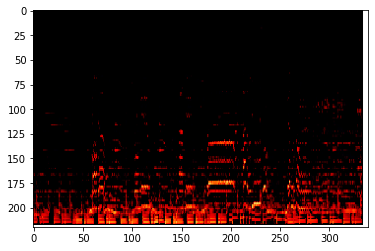

In [ ]:
#Example of a picture in the batch.
for batch, label in train_loader:
  plt.imshow(batch[5].permute(1,2,0))
  break

##Model #1  Pure CNN - without preprocessing

Lets say that kernel size is *ks*. After each layer we will do maxpooling with kernel size 2.

**Layer 1** - Conv2D kernel size 3 input channels n, output channels n_feature. 
**Layer 2** - Conv2D kernel size n input channels 2*n, output channels n_feature. 
**Layer 3** - Conv2D kernel size 2*n input channels 4*n, output channels n_feature. 
**Layer 4** - Conv2D kernel size 4*n input channels 8*n, output channels n_feature. 
**Layer 5** - Conv2D kernel size 8*n input channels 16*n, output channels n_feature. 


In [ ]:
class CNN1_Part1(nn.Module):
    def __init__(self, input_size=3, n_feature=8, kernel_size=3):
        super(CNN1_Part1, self).__init__()
        self.n_feature = n_feature
        
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=2*n_feature, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size)
        self.conv4 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size)
        self.conv5 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size)

        self.batchnorm1 = nn.BatchNorm2d(num_features=n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=16*n_feature)


        self.dropout = nn.Dropout(p=0.3, inplace=False)

        #For 3 layers use this lines of code
        # self.fc1 = nn.Linear(in_features=32*25*40, out_features=128)
        # self.fc2 = nn.Linear(in_features=128, out_features=10)

        #For 5 layers use this line of code
        self.fc1 = nn.Linear(in_features=128*8*4, out_features=10)
        
    def forward(self, x, verbose=False):

        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 5.
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)

        # For dropout uncomment this row
        # x = self.dropout(x)

        x = self.fc1(x)

        # If needed
        # x = self.fc2(x)


        x = F.softmax(x)

        return x

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


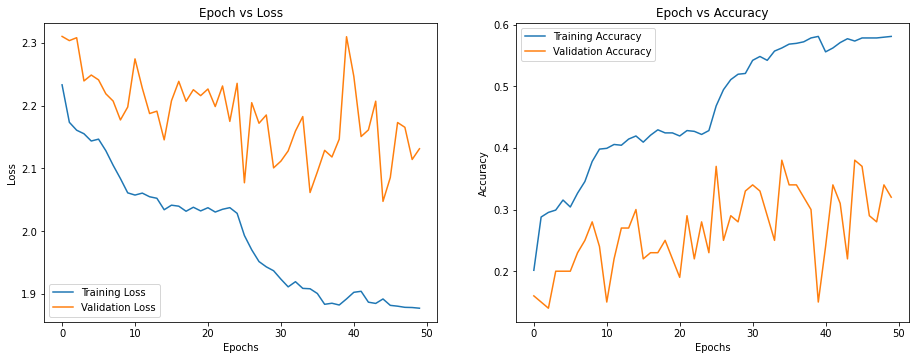

In [ ]:
#without dropout
model = CNN1_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs=50, lr = 0.001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

As we expected since our dataset is relatively small we shall expected overfitting. The are two possible ways we implemnted in order to overcome this challenge. 
1. Dropout - dropout is a techinque where random percentege of connection are nullified and it makes the model harder to memorize (overfit) the given data.
2. Data augmentation - its a techinuqe we use in the following parts. Using the currrent dataset we split each .wav of 30 sec, to 10 of .wav files each of 3 sec long. Meaning we increased our dataset using the same datawe already have.

##Trying Using Dropout

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


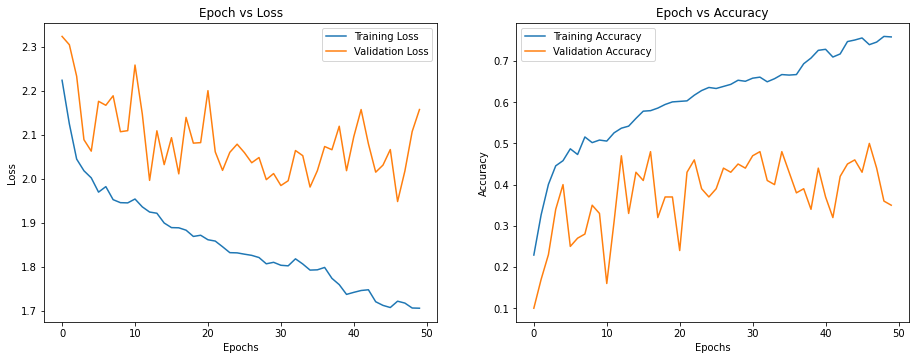

In [ ]:
#with dropout
model = CNN1_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs=50, lr = 0.001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

##Trying Using Different num of layers - num of layers 3.

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


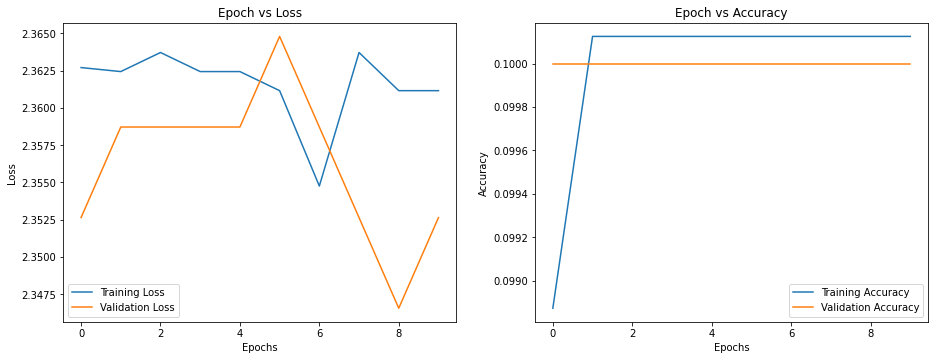

In [ ]:
#with dropout + layers =3
model = CNN1_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs=10, lr = 0.01, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Not Learning at all...

##Conclusions - Part 1
As we can see using dropout didnt affect our outcome that much. With Training accuracy 71%, validation accuracy 35%.
Our model is clearly overfiting. Also we experimented with the number of conv layers we used (smaller number of layers), in this architecture spotted no learning at all. 

#Part 2

##Background
<section>In this part we will also try built a cnn model, the major difference will be the preproccessing of the dataset. We implement data augmentation in following way:</section>
<section>Each .wav clip will be divided into 10 pieces. Each genre have 100 songs that are divided into 1000. </section>
<section>Each .wav clip will be used in order to create Mel-spectogram .png file</section>
In ideal case (all the .wav files are valid, and the Mel-spectogram have thesame dimensions) our dataset now is:
10000 - Mel-spectograms, (1000 for each genre).

**Run Background only once if already made the dataset move to "Load Mel-spectograms 3s"**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/'
original_folder = 'genres_original/'
new_folder = 'genres_3s'
if not os.path.exists(root_path+new_folder):
  os.mkdir(root_path+new_folder)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install pydub

In [ ]:
from pydub import AudioSegment
genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Generating 10 clips for each .wav file.

In [ ]:
for g in genres.values():
  print(f'{g}')
  #print(len(os.listdir(os.path.join(root_path, original_folder, g))))
  for filename in os.listdir(os.path.join(root_path, original_folder, g)):
    
    audio_file = os.path.join(root_path, original_folder, g, filename)

    new_path = os.path.join(root_path, new_folder, g)
    if not os.path.exists(new_path):
      os.mkdir(new_path)

    for w in range(0,10):
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      try:
        newAudio = AudioSegment.from_wav(audio_file, format='wav')
      except Exception as r:
        print(f"Audio file: {filename} wasnt added to the dataset")
      new = newAudio[t1:t2]
      audio_name = f'{filename.split(".")[0]}_{filename.split(".")[1]}_{w+1}.wav'
      if not os.path.exists(os.path.join(new_path, audio_name)):
        new.export(os.path.join(new_path, audio_name), format='wav')
print("All done")


Genre:blues, number of songs: 1000
length for current genre is: 1000
Genre:classical, number of songs: 1000
length for current genre is: 1000
Genre:country, number of songs: 1000
length for current genre is: 1000
Genre:disco, number of songs: 1000
length for current genre is: 1000
Genre:hiphop, number of songs: 1000
length for current genre is: 1000
Genre:jazz, number of songs: 1000
length for current genre is: 1000
Genre:metal, number of songs: 1000
length for current genre is: 1000
Genre:pop, number of songs: 1000
length for current genre is: 1000
Genre:reggae, number of songs: 1000
length for current genre is: 1000
Genre:rock, number of songs: 1000
length for current genre is: 274


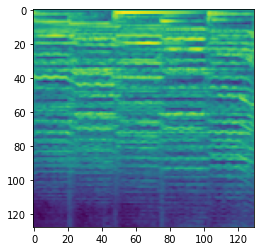

In [ ]:
mel_3s_folder = 'mel_3s'

if not os.path.exists(os.path.join(root_path, mel_3s_folder)):
  os.mkdir(os.path.join(root_path, mel_3s_folder))


for g in genres.values():
  print(f"Genre:{g}, number of songs: {len(os.listdir(os.path.join(root_path, new_folder, g)))}")
  new_path = os.path.join(root_path, mel_3s_folder, g)
  i=0
  if not os.path.exists(new_path):
    os.mkdir(new_path)
  else:
    #print(len(os.listdir(os.path.join(root_path, original_folder, g))))
    folder_len = len(os.listdir(os.path.join(root_path, mel_3s_folder, g)))
    print(f"length for current genre is: {folder_len}")
    if(folder_len==1000):
      continue
  for iter,filename in enumerate(os.listdir(os.path.join(root_path, new_folder, g))):
    mel_name = f'{filename.split("_")[0]}_{filename.split("_")[1]}_{iter}.png'
    if not os.path.exists(os.path.join(new_path, mel_name)):
      song  =  os.path.join(root_path, new_folder, g, filename)
      y,sr = librosa.load(song,duration=3)
      mels = librosa.feature.melspectrogram(y=y,sr=sr)
      mel_name = f'{filename.split("_")[0]}_{filename.split("_")[1]}_{i}.png'
      p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
      plt.savefig(os.path.join(new_path, mel_name))
    i+=1

print("All done")

##Load melspectograms of 3s.

In [ ]:
spectrograms_dir = "/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mel_3s/"
folder_names = [f'{spectrograms_dir}train/', f'{spectrograms_dir}test/', f'{spectrograms_dir}val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
# Create folder with training, testing and validation data.
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
    print("Already existing files")
  else:
    os.mkdir(f)
split_dataSet(spectrograms_dir, train_dir, val_dir, test_dir)
train_loader, val_loader, test_loader = create_Datasets(train_dir, val_dir, test_dir)
# Print number of images
print(train_loader.dataset.__len__())
print(val_loader.dataset.__len__())
print(test_loader.dataset.__len__())

Already existing files
Already existing files
Already existing files
['/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mel_3s/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mel_3s/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mel_3s/test/']
For genre: blues, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: classical, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: country, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: disco, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: hiphop, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: jazz, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: metal, num of train files: 800, num of validation

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

8000
1000
1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


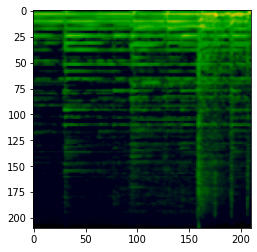

In [ ]:
#Example of one cell in a batch
for batch, label in train_loader:
  plt.imshow(batch[5].permute(1,2,0))
  break

##Model #2 PureCNN - with preprocessing

In [ ]:
class CNN1_Part2(nn.Module):
    def __init__(self, input_size=3, n_feature=4, kernel_size=3):
        super(CNN1_Part2, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=2*n_feature, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size)
        self.conv4 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size)
        self.conv5 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size)

        self.batchnorm1 = nn.BatchNorm2d(num_features=n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=16*n_feature)

        self.dropout = nn.Dropout(p=0.3, inplace=False)
        ##For iteration 1 uncomment this:
        # self.fc1 = nn.Linear(in_features=64*4*4, out_features=10)

        ##For iteration 3 uncomment this
        self.fc1 = nn.Linear(in_features=n_feature*16*4*4, out_features=10)
        
    def forward(self, x, verbose=False):
        #return torch.zeros((x.shape[0], 10)).to(device)
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 4.
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 5.
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x

  0%|          | 0/25 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


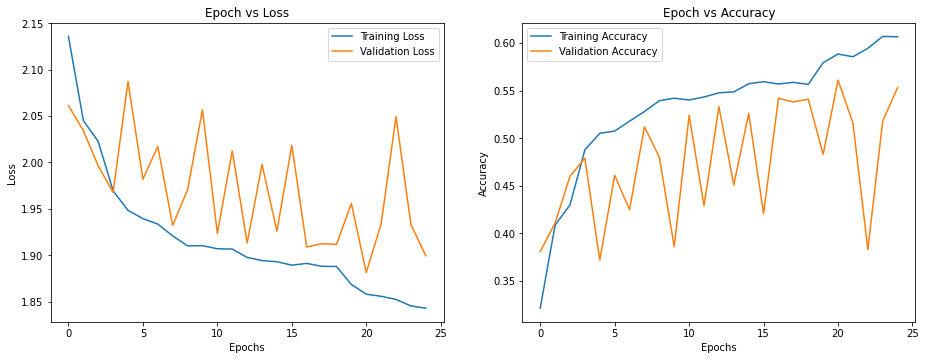

In [ ]:
model = CNN1_Part2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,epochs=25, lr = 0.001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

###Conclusion from iteration *1*
The fluctuations in validation loss is to high, meaning the learning rate is too high. High learning rate causes us to frequently jump from one side of the loss valley surface to another. Trying smaller learning rate will be logical.

  0%|          | 0/25 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


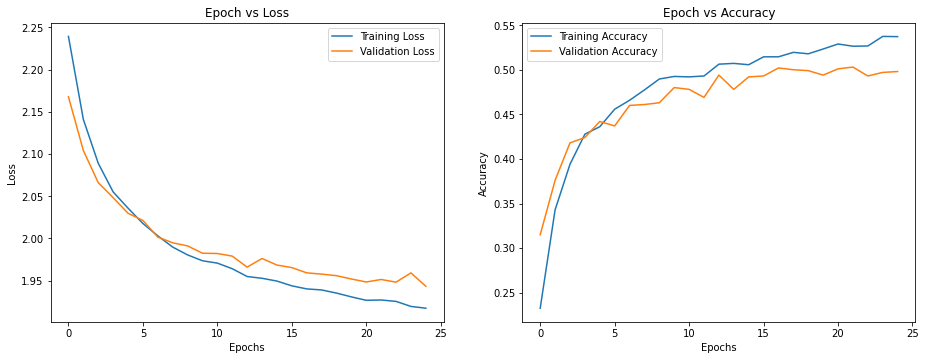

In [ ]:
model = CNN1_Part2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,epochs=25, lr = 0.0001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
torch.save(model.state_dict(), os.path.join(spectrograms_dir,"CNN1_Part1.pt"))

###Conclusion from iteration 2
As we can see our assumption was right, the fluctuations became smaller. Though, we can see that closing to epoch 25 there aslight gap opening that indicates overfiting. And the results of the training aren't exciting at all with 53% training and 50% validation. What can we do in order to tucklethis challenges? Change the architecture of the model.

In [ ]:
class CNN2_Part2(nn.Module):
    def __init__(self, input_size=3, n_feature=32, kernel_size=3):
        super(CNN2_Part2, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature*2, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(in_channels=n_feature*2, out_channels=n_feature*4, kernel_size=kernel_size)


        self.batchnorm1 = nn.BatchNorm2d(num_features=n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_feature*2)
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_feature*4)


        self.dropout = nn.Dropout(p=0.3, inplace=False)
        # self.fc1 = nn.Linear(in_features=32*26*26, out_features=64)
        self.fc1 = nn.Linear(in_features=n_feature*4*26*26, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x, verbose=False):

        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1)
        x = self.batchnorm1(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1)
        x = self.batchnorm2(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1)
        x = self.batchnorm3(x)


        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        # Fully connected layer 2.
        x = self.fc2(x)
        x = F.softmax(x)

        return x

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


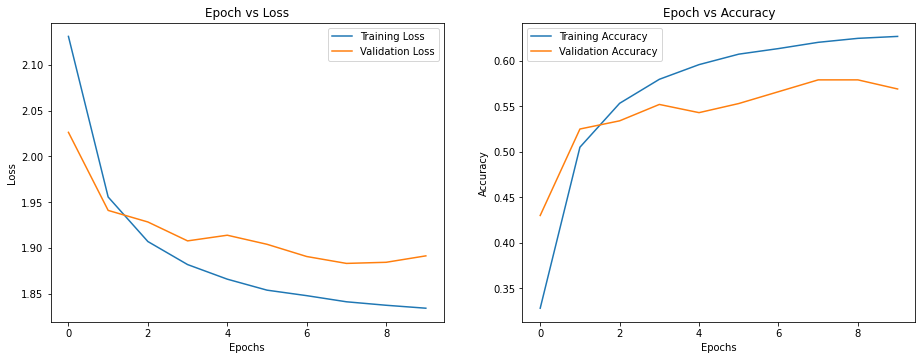

In [ ]:
model = CNN2_Part2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,epochs=10, lr = 0.0001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
torch.save(model.state_dict(), os.path.join(spectrograms_dir,"CNN2_Part2.pt"))

In [ ]:
test(model, test_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 1.8630, Accuracy: 601/1000 (60%)



###Conclusion from iteration 3
We can see that although we have less layers we could acheive higher validation accuracy of 55%. The saturation in learning comes after 10 epochs, and it becomes very difficult to train without making the notebook crash for n_feature > 32. But we wanted to see what would happen if we use CNN1_Part2 for higher feature value like in iteration 2. In the example preseneted below we didnt see any advantage in doing so.

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


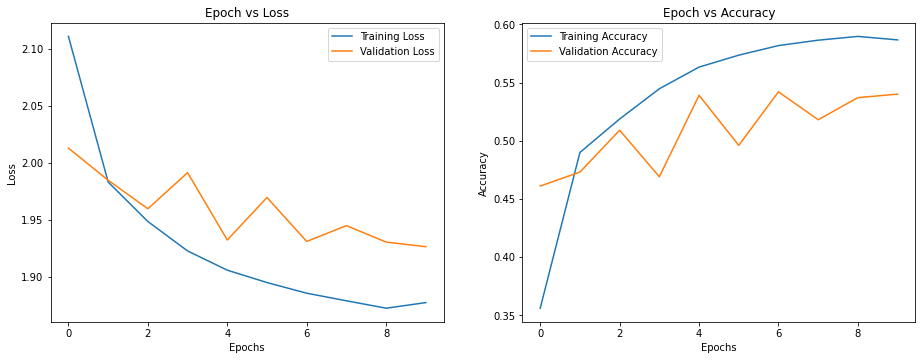

In [ ]:
model = CNN1_Part2(n_feature=32).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,epochs=10, lr = 0.0001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
test(model, test_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 1.9314, Accuracy: 529/1000 (53%)



##Conclusions - part 2
During implemetation of current part we encountered multiple challenges in different steps of making the final model. The first challenge was to create the current dataset. Mel-spectograms as such take a long computation time and colab notebook have limited resources for I/O operations (time and rate).
The second challenge was to load effectivately the dataset. Since the dataset includes 10k images loading it to ram memory was not an option. Here we started using the dataLoader and ImageFolder. Also we implemented a custom dataset since we found out that Crop and Transform are heavy computationally when used on all images before training. Without our customizatoin it could take about 20 min to load only the training files. After our customizatoin it takes 7 min to prepare the dataset (loading to ram, splitting). This techinque was used then for Part 1 dataset loading and for the rest of the project.
Possible drawbacks, saving the images with normalization isn't the right choice, but no evident was found that it's supposed to twist our results. Since the images are relativly big, creating new datasets with Mel-spectograms could be a problem.
Final results, best model is CNN2_Part2 with 60% of accuracy.

#Part 3

##Backgroung work
The following explanation is taken from [this paper](https://www.researchgate.net/publication/301510288_Multilingual_Deep_Neural_Network_For_Music_Genre_Classification). 

###Mel-Frequency Cepstral Coefficient (MFCC)
The Mel-Frequency Cepstral Coefficient (MFCC) is widely used in audio classification. It is obtained by averaging spectrogram values over Mel frequency bands using Mel-scale filters $ψ_λ (w)$. The following is the Mel-frequency spectrogram:
$M(α,t,λ)=1/2π ∫|α(t,w)|^2 |ψ_λ (w)|^2 dw$

Where $|α(t,w)|$ is the Fourier transform of $α$, $α$ is a sample vector of a audio file, and $λ$ is the center frequency of each $ψ_λ (w)$. It is effective over the length of a short time window 25 ms, and when using a window larger than 25 ms, the information lose becomes too important.

###Chroma feature
The chroma features were used with librosa library. We couldn't enter the documentation of the implementation since its [forbidden](https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/). The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma ([wikipedia](https://colab.research.google.com/drive/1gSs0vHrklwRZqrCL6umrLoSCiCFaItsJ#scrollTo=akoez5ROpN8e)). The main idea of chroma features is to aggregate for a given local time window (e.g. specified in beats or in seconds) all information that relates to a given chroma into a single coefficient. The deault number of chroma feature is 12 (but in part 3.2 we used 13 chroma coefficients).


###MFCC visualization
Each 3 sec .wav was transformed using the following parameters. This parameters are default ones since we couldnt find any theoretic justification for another parameters.
<section>
num_mfcc=13
n_fft=2048
hop_length=512
</section>

**Input: 3 sec .wav file**
<br>
**Output: 2D array, shape:(13,130)**

[-0.02429199 -0.02975464 -0.00961304 ...  0.13458252  0.0619812
 -0.00091553]
float32
00005_wav.wav


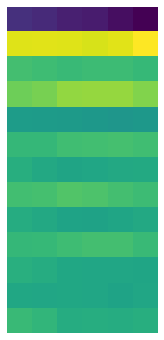

In [ ]:
TEST_PATH = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc'
if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))
file_path ='/content/gdrive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/blues/blues.00005.wav'
data, rate = librosa.load(file_path)
print(data)
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13
n_fft=2048
hop_length=512
mfcc = librosa.feature.mfcc(data[0:2999], SAMPLE_RATE, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
plt.imsave(os.path.join(TEST_PATH, "test.png"), mfcc, format='png')
print(mfcc.dtype)
plt.figure(figsize=(16, 6))
plt.imshow(mfcc.squeeze())
plt.axis('off');
audio_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}.wav'
print(audio_name)

###Create MFFC dataset
Creating the matrices dataset, using [numpy.save](https://https://numpy.org/doc/stable/reference/generated/numpy.save.html)

In [ ]:
DATASET_PATH ='/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'
TEST_PATH = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))


def save_mfcc(dataset_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))
            if not os.path.exists(os.path.join(TEST_PATH,semantic_label)):
              os.mkdir(os.path.join(TEST_PATH,semantic_label))

            # process all audio files in genre sub-dir
            for f in tqdm(filenames):

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        #print("{}, segment:{}".format(file_path, d+1))
                        pic_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}_segment_{d+1}'
                        if not os.path.exists(os.path.join(TEST_PATH,semantic_label,pic_name)):
                          #plt.imsave(os.path.join(TEST_PATH,semantic_label,pic_name), mfcc, format='png')
                          np.save(os.path.join(TEST_PATH,semantic_label,pic_name), mfcc)
                          pass

save_mfcc(DATASET_PATH, num_segments=10)



Processing: blues


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: classical


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: country


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: disco


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: hiphop


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: jazz


  0%|          | 0/99 [00:00<?, ?it/s]


Processing: metal


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: pop


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: reggae


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: rock


  0%|          | 0/100 [00:00<?, ?it/s]

###Chroma Visualization
Each 3 sec .wav was transformed using the following parameters. This parameters are default ones since we couldnt find any theoretic justification for another parameters.
<section>
num_mfcc=13
n_fft=2048
hop_length=512
chroma_bins = 12
</section>

**Input: 3 sec .wav file**
<br>
**Output: 2D array, shape:(12,130)**


[-0.02429199 -0.02975464 -0.00961304 ...  0.13458252  0.0619812
 -0.00091553]
float32
(12, 6)
00005_wav.wav


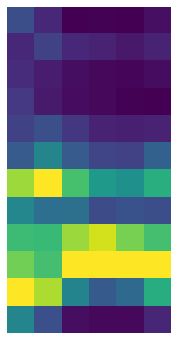

In [ ]:
TEST_PATH = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma'
if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))
file_path ='/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/blues/blues.00005.wav'
data, rate = librosa.load(file_path)
print(data)
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
chroma_stft = librosa.feature.chroma_stft(data[0:3000])
plt.imsave(os.path.join(TEST_PATH, "test.png"), chroma_stft, format='png')
print(chroma_stft.dtype)
print(chroma_stft.shape)
plt.figure(figsize=(12, 6))
plt.imshow(chroma_stft.squeeze())
plt.axis('off');
audio_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}.wav'
print(audio_name)

###Create chroma freqencies dataset.
Creating the matrices dataset, using [numpy.save](https://https://numpy.org/doc/stable/reference/generated/numpy.save.html)

In [ ]:
DATASET_PATH ='/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'
TEST_PATH = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))
# genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae'}
# genres = genres.values()
def save_chroma(dataset_path,n_fft=2048, hop_length=512, num_segments=10):
    """Extracts Chroma features from music dataset and saves them into pngs
        """

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_chromas_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):


        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))
            # if semantic_label in genres:
            #   continue
            if os.path.exists(os.path.join(TEST_PATH,semantic_label)):
              shutil.rmtree(os.path.join(TEST_PATH,semantic_label))
            os.mkdir(os.path.join(TEST_PATH,semantic_label))

            # process all audio files in genre sub-dir
            for f in tqdm(filenames):
              # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract chroma
                    chroma = librosa.feature.chroma_stft(signal[start:finish], sr=sample_rate, hop_length=hop_length, n_fft=n_fft)
                    chroma = chroma.T

                    # store only chroma feature with expected number of vectors
                    # print("{}, segment:{}".format(file_path, d+1))
                    if  len(chroma)<num_chromas_vectors_per_segment:
                      print("{}, segment:{}".format(file_path, d+1))
                      print(f"Chroma len: {len(chroma)}")
                    if len(chroma) == num_chromas_vectors_per_segment:
                      mat_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}_segment_{d+1}'
                      if  os.path.exists(os.path.join(TEST_PATH,semantic_label,mat_name)):
                        os.remove(os.path.join(TEST_PATH,semantic_label,mat_name))
                      np.save(os.path.join(TEST_PATH,semantic_label,mat_name), chroma)

    print("Done")      


save_chroma(DATASET_PATH, num_segments=10)



Processing: blues


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: classical


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/classical/classical.00051.wav, segment:10
Chroma len: 129

Processing: country


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/country/country.00007.wav, segment:10
Chroma len: 129

Processing: disco


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/disco/disco.00014.wav, segment:10
Chroma len: 129

Processing: hiphop


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/hiphop/hiphop.00032.wav, segment:10
Chroma len: 127

Processing: jazz


  0%|          | 0/99 [00:00<?, ?it/s]


Processing: metal


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: pop


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: reggae


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: rock


  0%|          | 0/100 [00:00<?, ?it/s]

Done


#Part 3.1 - New Approach
In this chapter we decided to try another approach since we halted our progress with Mel-spectograms. Instead of using Mel-spectograms we can used features that can be represented in matrix in order to use previous knowledge and models.
From the Kaggle [notebook](https://https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend#Introduction)
we saw 2 features that can be represented as a 2D array. Meaning we can use our previous knowledge but instead saving images we save numpy arrays and use 1 as input channel.
**The first feature is: MMFC** - The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. In our work we used 13 coefficients. 
**The second featue is: Chroma Frequencies**  - Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.


##Custom dataset - for matrices.
In this part we created custom dataset thatloads all the matrices beforehand to ram since there ~10Kmatrices of 7 kB each.
Creating and saving and loading all this matrices is relatively faster if we are comparing it too Mel-spectograms from Part 2.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, root):
    self.ds = []
    for i,genre in enumerate(os.listdir(root)):

      for sample in tqdm(os.listdir(os.path.join(root, genre))):
        path = os.path.join(root, genre,sample)
        mat = np.load(path)
        mat = torch.from_numpy(mat)
        mat = torch.unsqueeze(mat,0)
        self.ds.append((mat,i))


  def __getitem__(self, index):
    return self.ds[index]
    
  def __len__(self):
    return len(self.ds)

##Final CNN model for part 3.1 - using mffc/chroma

This model is inspired by CNN architecture [in lecture 5](https://gist.github.com/nirshlezinger1/9129e622b72c0bae24f2ca04dbfb9661),  and many other papers using cnn for audio analyzing. We achieved this architectute though many try and test experiments. The basic principal of this model is trying make the model as deeper as possible given the matrix dimensions. The first 3 layers, are just convolutional with batch normalization and relu activation function, the other layers include pooling, resulting the matrix dimensions become smaller, though the number of channels becomes bigger.

In [ ]:
class CNN1_Part3(nn.Module):
    def __init__(self, input_size=1, n_feature=3, kernel_size=3):
        super(CNN1_Part3, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv3 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv4 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size, padding='same')
        self.conv5 = nn.Conv2d(in_channels=16*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv6 = nn.Conv2d(in_channels=8*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv7 = nn.Conv2d(in_channels=4*n_feature, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv8 = nn.Conv2d(in_channels=2*n_feature, out_channels=n_feature, kernel_size=kernel_size, padding='same')

        self.batchnorm1 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=16*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm6 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm7 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm8 = nn.BatchNorm2d(num_features=n_feature)

        self.dropout = nn.Dropout(p=0.3, inplace=False)
        self.fc1 = nn.Linear(in_features=3*6*2, out_features=10)
        
    def forward(self, x, verbose=False):

        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batchnorm1(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchnorm2(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchnorm3(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1,ceil_mode=True)
        x = self.batchnorm4(x)
        x = self.dropout(x)

        # Conv layer 5.
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1,ceil_mode=True)
        x = self.batchnorm5(x)

        # Conv layer 6.
        x = self.conv6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1,ceil_mode=True)
        x = self.batchnorm6(x)
        x = self.dropout(x)

        # Conv layer 7.
        x = self.conv7(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1,ceil_mode=True)
        x = self.batchnorm7(x)

        # Conv layer 8.
        x = self.conv8(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1,ceil_mode=True)
        x = self.batchnorm8(x)
        x = self.dropout(x)


        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.softmax(x)

        return x

In [ ]:
test(model, test_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 1.6024, Accuracy: 866/999 (87%)



In [ ]:
torch.save(model.state_dict(), os.path.join(root,"CNN1_Part3_DropoutIncluded.pt"))

##Using MFFC feature

In [ ]:
root = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/'
folder_names = [f'{root}train/', f'{root}test/', f'{root}val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
# Create folder with training, testing and validation data.
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
    print("Already existing files")
  else:
    os.mkdir(f)
split_dataSet(root, train_dir, val_dir, test_dir)

Already existing files
Already existing files
Already existing files
['/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/test/']
For genre: blues, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: classical, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: country, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: disco, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: hiphop, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: jazz, num of train files: 792, num of validation files: 99, num of test files: 99
For genre: metal, num of train files: 800, num 

In [ ]:
train_ds = CustomDataset(train_dir)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= 64, shuffle=True, num_workers=2)
val_ds = CustomDataset(val_dir)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size= 64, shuffle=True, num_workers=1)
test_ds = CustomDataset(test_dir)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size= 64, shuffle=True, num_workers=1)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


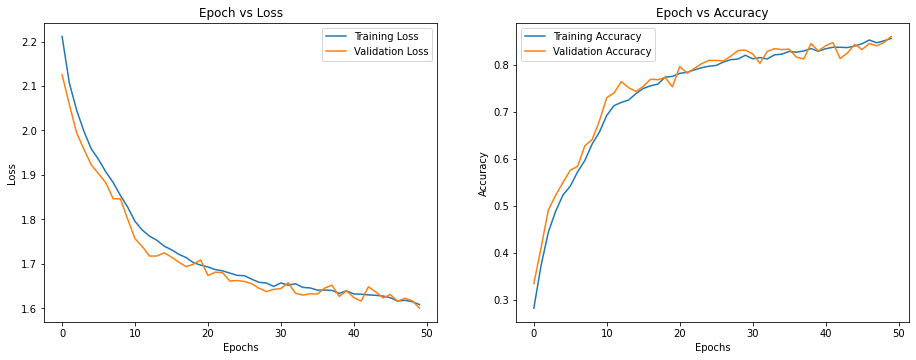

In [ ]:
model = CNN1_Part3().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs= 50, lr = 0.0005, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

##Conclusions - MFFC training
Since creating the MFFC dataset was much easier then Mel-spectromgs images. We experimented a lot with different models. From the start we saw that a convolution model memorizes the dataset and reaches the higher accuracy then in Part 2. The running results for this model (with/out dropout) are summarized in the folllowing table.


Model | learning rate | Test Accuracy
-------------------|------------------|----------
Without dropout       | 0.001 | 82% 
Without dropout       | 0.001 | 76% 
With dropout       | 0.001 | 82% 
With dropout       | 0.0005 | 87% 
---

##Using chroma feature

In [ ]:
DATASET_PATH ='/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'
TEST_PATH = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))
# genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae'}
# genres = genres.values()
def save_chroma(dataset_path,n_fft=2048, hop_length=512, num_segments=10):
    """Extracts Chroma features from music dataset and saves them into pngs
        """

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_chromas_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):


        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))
            # if semantic_label in genres:
            #   continue
            if os.path.exists(os.path.join(TEST_PATH,semantic_label)):
              shutil.rmtree(os.path.join(TEST_PATH,semantic_label))
            os.mkdir(os.path.join(TEST_PATH,semantic_label))

            # process all audio files in genre sub-dir
            for f in tqdm(filenames):
              # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract chroma
                    chroma = librosa.feature.chroma_stft(signal[start:finish], sr=sample_rate, hop_length=hop_length, n_fft=n_fft)
                    chroma = chroma.T

                    # store only chroma feature with expected number of vectors
                    # print("{}, segment:{}".format(file_path, d+1))
                    if  len(chroma)<num_chromas_vectors_per_segment:
                      print("{}, segment:{}".format(file_path, d+1))
                      print(f"Chroma len: {len(chroma)}")
                    if len(chroma) == num_chromas_vectors_per_segment:
                      mat_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}_segment_{d+1}.png'
                      if  os.path.exists(os.path.join(TEST_PATH,semantic_label,mat_name)):
                        os.remove(os.path.join(TEST_PATH,semantic_label,mat_name))
                      np.save(os.path.join(TEST_PATH,semantic_label,mat_name), chroma)

    print("Done")      


save_chroma(DATASET_PATH, num_segments=10)



Processing: blues


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: classical


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/classical/classical.00051.wav, segment:10
Chroma len: 129

Processing: country


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/country/country.00007.wav, segment:10
Chroma len: 129

Processing: disco


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/disco/disco.00014.wav, segment:10
Chroma len: 129

Processing: hiphop


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/hiphop/hiphop.00032.wav, segment:10
Chroma len: 127

Processing: jazz


  0%|          | 0/99 [00:00<?, ?it/s]


Processing: metal


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: pop


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: reggae


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: rock


  0%|          | 0/100 [00:00<?, ?it/s]

Done


In [ ]:
root = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices/'
folder_names = [f'{root}train/', f'{root}test/', f'{root}val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
# Create folder with training, testing and validation data.
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
    print("Already existing files")
  else:
    os.mkdir(f)
split_dataSet(root, train_dir, val_dir, test_dir)
train_ds = CustomDataset(train_dir)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= 64, shuffle=True, num_workers=2)
val_ds = CustomDataset(val_dir)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size= 64, shuffle=True, num_workers=1)
test_ds = CustomDataset(test_dir)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size= 64, shuffle=True, num_workers=1)

Already existing files
Already existing files
Already existing files
['/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/chroma_matrices/test/']
For genre: blues, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: classical, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: country, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: disco, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: hiphop, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: jazz, num of train files: 792, num of validation files: 99, num of test files: 99
For genre: metal, num of train file

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


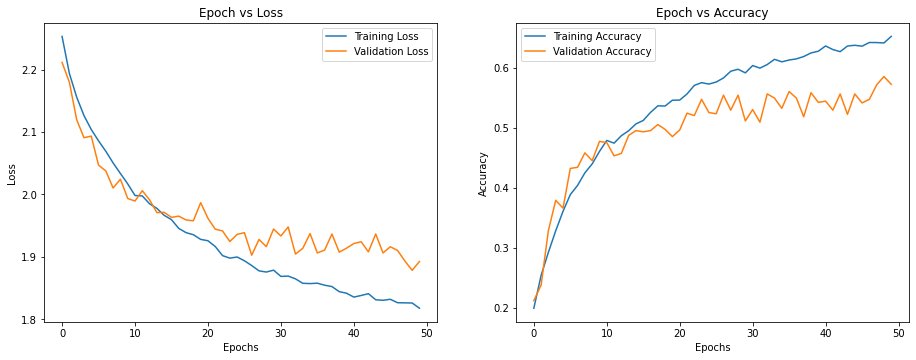

In [ ]:
model = CNN1_Part3().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs= 50, lr = 0.0005, weight_decay=0.001)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
torch.save(model.state_dict(), os.path.join(root,"CNN1_Part3_Chroma.pt"))

##Conclusions - Chroma training
Thoughout the whole model training for chroma features we encountered an accuracy glass ceiling of 60% for every architecture we tried. We assume that chroma feature of songs isn't vary too much, meaning it's not that helpfull alone.

#Part 3.2 - Combining MFCC/Chroma
From part 3.1, we see that MFCC feature is much more prodactive for the same model. Here we will try to enhance the model of MFCC by combining the 2 matrices, as 2 inputs for the model. In order to do that we need to reconstruct our database. In order to do that I shall concat the previous datasets into one. But since the shape of an MFCC tensor is 1,130,13 and the shape if Chroma tensor is 1,130,12 I shall use 13 bins of chroma feature.

##Creating the correspondig dataset
**Run only once**<br>
Since we need a 13 bins Chroma feature we construct the dataset individuaaly for this part while for MFFC we are using the same dataset as we used in part 3.1.

In [ ]:
DATASET_PATH ='/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original'
TEST_PATH = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/padded_chroma_matrices'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

if not os.path.exists(os.path.join(TEST_PATH)):
  os.mkdir(os.path.join(TEST_PATH))
# genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae'}
# genres = genres.values()
def save_chroma(dataset_path,n_fft=2048, hop_length=512, num_segments=10):
    """Extracts Chroma features from music dataset and saves them into pngs
        """

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_chromas_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):


        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))
            # if semantic_label in genres:
            #   continue
            if os.path.exists(os.path.join(TEST_PATH,semantic_label)):
              shutil.rmtree(os.path.join(TEST_PATH,semantic_label))
            os.mkdir(os.path.join(TEST_PATH,semantic_label))

            # process all audio files in genre sub-dir
            for f in tqdm(filenames):
              # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract chroma
                    chroma = librosa.feature.chroma_stft(signal[start:finish], sr=sample_rate, hop_length=hop_length, n_fft=n_fft, n_chroma=13)
                    chroma = chroma.T

                    # store only chroma feature with expected number of vectors
                    # print("{}, segment:{}".format(file_path, d+1))
                    if  len(chroma)<num_chromas_vectors_per_segment:
                      print("{}, segment:{}".format(file_path, d+1))
                      print(f"Chroma len: {len(chroma)}")
                    if len(chroma) == num_chromas_vectors_per_segment:
                      mat_name = f'{file_path.split(".")[1]}_{file_path.split(".")[2]}_segment_{d+1}.png'
                      if  os.path.exists(os.path.join(TEST_PATH,semantic_label,mat_name)):
                        os.remove(os.path.join(TEST_PATH,semantic_label,mat_name))
                      np.save(os.path.join(TEST_PATH,semantic_label,mat_name), chroma)

    print("Done")      


save_chroma(DATASET_PATH, num_segments=10)



Processing: blues


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: classical


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/classical/classical.00051.wav, segment:10
Chroma len: 129

Processing: country


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/country/country.00007.wav, segment:10
Chroma len: 129

Processing: disco


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/disco/disco.00014.wav, segment:10
Chroma len: 129

Processing: hiphop


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/genres_original/hiphop/hiphop.00032.wav, segment:10
Chroma len: 127

Processing: jazz


  0%|          | 0/99 [00:00<?, ?it/s]


Processing: metal


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: pop


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: reggae


  0%|          | 0/100 [00:00<?, ?it/s]


Processing: rock


  0%|          | 0/100 [00:00<?, ?it/s]

Done


##New split function
Since we need to divide evenlly the dataset of Chroma matrices and MFFC we implemeted a new DataSplit function to assure each matrix will correspond to the same .wav segment.

In [ ]:
def split_dataSet(root_path1,root_path2,
                  train_path1,train_path2,
                  valid_path1,valid_path2,
                  test_path1, test_path2):
  '''root_path - is the root folder where the spectograms allocated.
  train_path, valid_path, test_path - folder where the train, validation and testing data respectively will be.'''
  folder_names = [train_path1, valid_path1, test_path1, train_path2, valid_path2, test_path2]
  print(folder_names)
  # Loop over all genres.
  genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
  for g in genres.values():
    # find all images & split in train, test, and validation
    src_file_paths= []
    src_file_paths_copy= []
    for im in glob.glob(os.path.join(root_path1, f'{g}',"*.png*"), recursive=True):
      src_file_paths.append(im)
      src_file_paths_copy.append(im.replace("mfcc_matrix","padded_chroma_matrices"))

    p = list(zip(src_file_paths,src_file_paths_copy))
    random.shuffle(p)
    src_file_paths,src_file_paths_copy = zip(*p)

    total_len = len(src_file_paths)
    idx_1 = int(math.ceil(0.1*total_len))
    idx_2 = int(math.ceil(0.2*total_len))

    test_files = src_file_paths[0:idx_1]
    val_files = src_file_paths[idx_1:idx_2]
    train_files = src_file_paths[idx_2:]

    test_files2 = src_file_paths_copy[0:idx_1]
    val_files2 = src_file_paths_copy[idx_1:idx_2]
    train_files2 = src_file_paths_copy[idx_2:]


    print(f"For genre: {g}, num of train files: {len(train_files)}, num of validation files:"\
    +f" {len(val_files)}, num of test files: {len(test_files)}")
    #  make destination folders for train and test images
    for f in folder_names:
      if not os.path.exists(os.path.join(f , f"{g}")):
        os.mkdir(os.path.join(f , f"{g}"))

    # copy training and testing images over
    for f in train_files:
      shutil.copy(f, os.path.join(train_path1 + f"{g}"))
    for f in test_files:
      shutil.copy(f, os.path.join(test_path1 + f"{g}"))
    for f in val_files:
      shutil.copy(f, os.path.join(valid_path1 + f"{g}"))
    for f in train_files2:
      shutil.copy(f, os.path.join(train_path2 + f"{g}"))
    for f in test_files2:
      shutil.copy(f, os.path.join(test_path2 + f"{g}"))
    for f in val_files2:
      shutil.copy(f, os.path.join(valid_path2 + f"{g}"))

In [ ]:
root1 = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/'
root2 = '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/padded_chroma_matrices/'

folder_names = [f'{root1}train/',f'{root2}train/', f'{root1}test/',f'{root2}test/', f'{root1}val/',f'{root2}val/']
train_dir1 = folder_names[0]
test_dir1 = folder_names[2]
val_dir1 = folder_names[4]
train_dir2 = folder_names[1]
test_dir2 = folder_names[3]
val_dir2 = folder_names[5]
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
    print("Already existing files")
  else:
    os.mkdir(f)
split_dataSet(root1, root2, train_dir1, train_dir2, val_dir1, val_dir2, test_dir1, test_dir2)

Already existing files
Already existing files
Already existing files
['/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/mfcc_matrix/test/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/padded_chroma_matrices/train/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/padded_chroma_matrices/val/', '/content/drive/My Drive/Intro_to_Deep_Learning/Genre_Classification/kaggle/Data/padded_chroma_matrices/test/']
For genre: blues, num of train files: 800, num of validation files: 100, num of test files: 100
For genre: classical, num of train files: 799, num of validation files: 100, num of test files: 100
For genre: country, num of train files: 799, num of validation files: 100, num of test files: 1

## Custom dataset for combining features
Since we wanted to combine both features. We implemntd it as a 2 channels tensor meaning each component in the dataloader batch is an (mat1, mat2), target. Where mat1===MFFC(signal), mat2===Chroma(signal). The data matrices are the corresponding feature of the same .wav segment.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, root):
    self.ds = []
    for i,genre in enumerate(os.listdir(root)):

      for sample in tqdm(os.listdir(os.path.join(root, genre))):
        path = os.path.join(root, genre,sample)
        mat1 = np.load(path)
        mat1 = torch.from_numpy(mat1)
        mat1 = torch.unsqueeze(mat1,0)
        path2= os.path.join(root.replace("mfcc_matrix","padded_chroma_matrices"), genre,sample)
        mat2 = np.load(path2)
        mat2 = torch.from_numpy(mat2)
        mat2 = torch.unsqueeze(mat2,0)
        self.ds.append(((mat1,mat2),i))


  def __getitem__(self, index):
    return self.ds[index]
    
  def __len__(self):
    return len(self.ds)

In [ ]:
train_ds = CustomDataset(train_dir1)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= 64, shuffle=True, num_workers=2)
val_ds = CustomDataset(val_dir1)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size= 64, shuffle=True, num_workers=1)
test_ds = CustomDataset(test_dir1)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size= 64, shuffle=True, num_workers=1)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

##Final CNN model for part 3.2 - Combining Chroma and MFCC
MFCC Branch - Its the same architecture as in Part 3.1. No changes were made except some experiments with the dropout layers. As for the chroma feature extraction, we couldn't find the optimal modal, architectures that were used are the same as part 3.1 and the uncommented feed-forward architecture.

In [ ]:
class CNN2_Part3(nn.Module):
    def __init__(self, input_size=1, n_feature=3, kernel_size=3):
        super(CNN2_Part3, self).__init__()
        self.n_feature = n_feature


        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv3 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv4 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size, padding='same')
        self.conv5 = nn.Conv2d(in_channels=16*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv6 = nn.Conv2d(in_channels=8*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv7 = nn.Conv2d(in_channels=4*n_feature, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv8 = nn.Conv2d(in_channels=2*n_feature, out_channels=n_feature, kernel_size=kernel_size, padding='same')

        self.batchnorm1 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=16*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm6 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm7 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm8 = nn.BatchNorm2d(num_features=n_feature)

        self.conv1_2 = nn.Conv2d(in_channels=input_size, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv2_2 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv3_2 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv4_2 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size, padding='same')
        self.conv5_2 = nn.Conv2d(in_channels=16*n_feature, out_channels=8*n_feature, kernel_size=kernel_size, padding='same')
        self.conv6_2 = nn.Conv2d(in_channels=8*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv7_2 = nn.Conv2d(in_channels=4*n_feature, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv8_2 = nn.Conv2d(in_channels=2*n_feature, out_channels=n_feature, kernel_size=kernel_size, padding='same')

        self.batchnorm1_2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm2_2 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm3_2= nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm4_2 = nn.BatchNorm2d(num_features=16*n_feature)
        self.batchnorm5_2 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm6_2 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm7_2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm8_2 = nn.BatchNorm2d(num_features=n_feature)

        #c Expiriment
        # self.fc2 = nn.Linear(in_features=130*13, out_features=1024)
        # self.fc3 = nn.Linear(in_features=1024, out_features=512)
        # self.fc4 = nn.Linear(in_features=512, out_features=256)
        # self.fc5 = nn.Linear(in_features=256, out_features=128)
        # self.fc6 = nn.Linear(in_features=128, out_features=36)

        self.dropout = nn.Dropout(p=0.3, inplace=False)
        self.fc1 = nn.Linear(in_features=3*6*2*2, out_features=10)
        
    def forward(self, data):

      input1 = data[0]
      input2 = data[1]


      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      # Conv layer 1.
      input1= self.conv1(input1)
      input1= F.relu(input1)
      input1= self.batchnorm1(input1)
      # Conv layer 2.
      input1= self.conv2(input1)
      input1= F.relu(input1)
      input1= self.batchnorm2(input1)
      # Conv layer 3.
      input1= self.conv3(input1)
      input1= F.relu(input1)
      input1= self.batchnorm3(input1)     
      # Conv layer 4.
      input1= self.conv4(input1)
      input1= F.relu(input1)
      input1= F.max_pool2d(input1, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input1= self.batchnorm4(input1)
      input1 = self.dropout(input1)
      # Conv layer 5.
      input1= self.conv5(input1)
      input1= F.relu(input1)
      input1= F.max_pool2d(input1, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input1= self.batchnorm5(input1)
      # Conv layer 6.
      input1= self.conv6(input1)
      input1= F.relu(input1)
      input1= F.max_pool2d(input1, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input1= self.batchnorm6(input1)
      input1 = self.dropout(input1)
      # Conv layer 7.
      input1= self.conv7(input1)
      input1= F.relu(input1)
      input1= F.max_pool2d(input1, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input1= self.batchnorm7(input1)
      # Conv layer 8.
      input1= self.conv8(input1)
      input1= F.relu(input1)
      input1= F.max_pool2d(input1, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input1= self.batchnorm8(input1)
      input1 = self.dropout(input1)
      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      input2= self.conv1_2(input2)
      input2= F.relu(input2)
      input2= self.batchnorm1_2(input2)
      # Conv layer 2.
      input2= self.conv2_2(input2)
      input2= F.relu(input2)
      input2= self.batchnorm2_2(input2)
      # Conv layer 3.
      input2= self.conv3_2(input2)
      input2= F.relu(input2)
      input2= self.batchnorm3_2(input2)     
      # Conv layer 4.
      input2= self.conv4_2(input2)
      input2= F.relu(input2)
      input2= F.max_pool2d(input2, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input2= self.batchnorm4_2(input2)
      # Conv layer 5.
      input2= self.conv5_2(input2)
      input2= F.relu(input2)
      input2= F.max_pool2d(input2, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input2= self.batchnorm5_2(input2)
      input2 = self.dropout(input2)
      # Conv layer 6.
      input2= self.conv6_2(input2)
      input2= F.relu(input2)
      input2= F.max_pool2d(input2, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input2= self.batchnorm6_2(input2)
      # Conv layer 7.
      input2= self.conv7_2(input2)
      input2= F.relu(input2)
      input2= F.max_pool2d(input2, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input2= self.batchnorm7_2(input2)
      input2 = self.dropout(input2)
      # Conv layer 8.
      input2= self.conv8_2(input2)
      input2= F.relu(input2)
      input2= F.max_pool2d(input2, kernel_size=2, stride=2, padding=1,ceil_mode=True)
      input2= self.batchnorm8_2(input2)
      
      
      # input2 = torch.flatten(input2, 1)
      # input2 = self.fc2(input2)
      # input2 =self.dropout(input2)
      # input2 = self.fc3(input2)
      # input2 =self.dropout(input2)
      # input2 = self.fc4(input2)
      # input2 =self.dropout(input2)
      # input2 = self.fc5(input2)
      # input2 =self.dropout(input2)       
      # input2 = self.fc6(input2)
      # input2 =self.dropout(input2)
      #Fully Conected for the chroma mat, max accuracy  achieved 79%



      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      # Fully connected layer 1.
      input1 = torch.flatten(input1, 1)
      input2 = torch.flatten(input2, 1)

      combined = torch.cat((input1,input2), dim=1)
      # print(combined.shape)

      combined = self.fc1(combined)
      combined = F.softmax(combined)

      return combined

  0%|          | 0/30 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


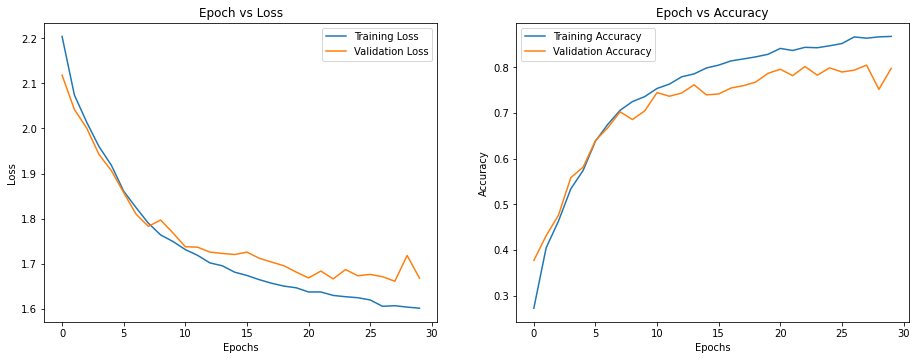

In [ ]:
model = CNN2_Part3().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs= 30, lr = 0.0005, weight_decay=0.0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
test(model, test_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 1.6530, Accuracy: 815/999 (82%)



In [ ]:
torch.save(model.state_dict(), os.path.join(root1,"CNN2_Part3.pt"))

##Conclusions - Combining MFCC and Chroma features.
As we can see in the results, we couldnt achieve higher test accuracy then from part 3.1. We assume that the Chroma frequency doesnt hold information that is uncorelletad with the MFFC coeeficients and hence it couldnt help the model to learn new information. The best result for this section is **82% Test accuracy**